# ANOMALY DETECTION for a Production Floor

## Introduction

Anomaly detection is process of identifying outliers in data and detecting rare occurrences which are different from the established pattern of behaviors. This technique is extremly important in operational processes in many industries. This solution will also lay the ground to start predicting outliers on a machine level.

This notebook covers :


1. Exploratory Data Analysis

2. Train a Keras LSTM auto-encoder using prepared training data

3. Log the model to Snowflake Registry

4. Calculate the Threshold from the reconstruction convolutional autoencoder model

4. Create a threshold range for various sensors and carry inference 

5. Detect anomalies on test dataset


The dataset consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals.


#### Model : 

The autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.


## Setup

In [ ]:
!pip install tensorflow==2.12.0

## Import Packages


In [10]:
import json
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.functions import *
# import libraries

import os, configparser ,json ,logging
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from numpy.random import seed

#from tensorflow import set_random_seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


from IPython.display import display, HTML, Image , Markdown

import streamlit as st
import pandas as pd
from datetime import datetime, timedelta

# We can also use Snowpark for our analyses!
from snowflake.snowpark.context import get_active_session
session = get_active_session()

from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import (
roc_auc_score,  
precision_score, 
recall_score, 
confusion_matrix)
import pprint

# Add a query tag to the session.
session.query_tag = {"origin":"sf_sit-is", "name":"anomaly_detection", "version":{"major":1, "minor":0}}
solution_prefix = session.get_current_warehouse()
solution_prefix

In [ ]:
import pandas as pd
import numpy as np

# Parameters
num_records = 1000
start_time = pd.Timestamp("2024-06-12 10:52:00")
interval = pd.Timedelta(minutes=10)

# Generate timestamps
timestamps = [start_time + i * interval for i in range(num_records)]

# Generate normal sensor data
np.random.seed(42)
temperature = np.random.normal(loc=0.06, scale=0.002, size=num_records)
vibration = np.random.normal(loc=0.075, scale=0.002, size=num_records)
motor_rpm = np.random.normal(loc=0.045, scale=0.001, size=num_records)
motor_amps = np.random.normal(loc=0.084, scale=0.002, size=num_records)

# Extra columns
factory_floors = np.random.choice(["Floor A", "Floor B", "Floor C"], num_records)
production_units = np.random.choice(["Unit 1", "Unit 2", "Unit 3", "Unit 4", "Unit 5"], num_records)
shifts = np.random.choice(["Morning", "Afternoon", "Night"], num_records)
operator_ids = np.random.randint(1000, 1100, num_records)  # Random operator IDs between 1000 and 1099
machine_status = np.random.choice(["Running", "Idle", "Maintenance"], num_records, p=[0.8, 0.15, 0.05])

# Introduce subtle anomalies in the last 200 records (10 hours at 10-minute intervals)
anomaly_start_index = num_records - 200
temperature[anomaly_start_index:] += np.random.uniform(0.005, 0.01, size=200)
vibration[anomaly_start_index:] += np.random.uniform(0.003, 0.007, size=200)
motor_rpm[anomaly_start_index:] -= np.random.uniform(0.002, 0.005, size=200)
motor_amps[anomaly_start_index:] += np.random.uniform(0.005, 0.01, size=200)

# Flag anomalies
anomaly_flag = np.zeros(num_records, dtype=int)
anomaly_flag[anomaly_start_index:] = 1

# Update MACHINE_STATUS for anomalies
machine_status = np.where(anomaly_flag == 1, "Quality Issue", machine_status)

# Create the DataFrame
data = {
    "TEMPERATURE": temperature,
    "VIBRATION": vibration,
    "MOTOR_RPM": motor_rpm,
    "MOTOR_AMPS": motor_amps,
    "MEASURE_TS": timestamps,
    "FACTORY_FLOOR": factory_floors,
    "PRODUCTION_UNIT": production_units,
    "SHIFT": shifts,
    "OPERATOR_ID": operator_ids,
    "MACHINE_STATUS": machine_status,
    "ANOMALY_FLAG": anomaly_flag,
}
snow_pd = pd.DataFrame(data)

# Drop ANOMALY_FLAG before saving to the Snowflake table
snow_pd = snow_pd.drop('ANOMALY_FLAG', axis=1)

# Convert to Snowpark DataFrame
spdf = session.create_dataframe(snow_pd)

# Save to Snowflake table
spdf.write.save_as_table("SENSOR_PREPARED", mode="overwrite")


#### Call for Action :

Unzip the folders in the /data/NASA_Dataset directory. The files in the *_pt1.zip folder will be used.

The following cell reads the files from the unzipped folder and creates a pandas dataframe. The timestamp associated with the sensor readings are recorded in the file name. This is set as the index of the pandas dataframe.

## DATA PROCESSING
#### 1.Exploration on SENSOR_PREPARED

In [16]:
spdf.show()

-----------------------------------------------------
|"Bearing1"  |"Bearing2"  |"Bearing3"  |"Bearing4"  |
-----------------------------------------------------
|0.060236    |0.074227    |0.083926    |0.044443    |
|0.061455    |0.073844    |0.084457    |0.045081    |
|0.061361    |0.075609    |0.082837    |0.045118    |
|0.061665    |0.073279    |0.084879    |0.044172    |
|0.061944    |0.074593    |0.082626    |0.044659    |
|0.061231    |0.074172    |0.082022    |0.04384     |
|0.06228     |0.075808    |0.084372    |0.044272    |
|0.05989     |0.075115    |0.084506    |0.043974    |
|0.062371    |0.075505    |0.082238    |0.044171    |
|0.060837    |0.074648    |0.080552    |0.043602    |
-----------------------------------------------------



In [17]:
# set random seed
seed(10)
tf.random.set_seed(10)

In [18]:
# Represent the dimensionality of the DataFrame.
snow_pd.shape

(565, 4)

In [19]:
# Calculate statistics for the dataset
snow_pd.describe()

,Bearing1,Bearing2,Bearing3,Bearing4
count,565.000000,565.000000,565.000000,565.000000
mean,0.061293,0.074757,0.078144,0.044065
std,0.001829,0.001018,0.001987,0.000525
min,0.058293,0.072106,0.073828,0.042777
25%,0.060349,0.074040,0.076657,0.043697
50%,0.060920,0.074754,0.077741,0.044053
75%,0.061575,0.075505,0.079406,0.044408
max,0.070135,0.077802,0.084879,0.045920


In [20]:
#Distinct values per column
unique_values = []
for column in snow_pd.columns:
    print(column, ":", snow_pd[column].nunique())

Bearing1 : 532
Bearing2 : 529
Bearing3 : 540
Bearing4 : 484


In [21]:
# Quickly test if the object looks as desired 
snow_pd.columns


,Bearing1,Bearing2,Bearing3,Bearing4
MEASURE_TS,,,,
2023-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2023-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2023-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2023-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2023-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [ ]:
snow_pd.head()


In [ ]:
snow_pd.set_index('MEASURE_TS', inplace=True)

print(snow_pd.head())

In [ ]:

max_timestamp = snow_pd.index.max()
min_timestamp = snow_pd.index.min()
print(min_timestamp, max_timestamp)

In [23]:
# Ensure the index is a DatetimeIndex
snow_pd.index = pd.to_datetime(snow_pd.index)

# Split the dataset
train = snow_pd[:'2024-06-18 00:02:00']
test = snow_pd['2024-06-18 00:12:00':]

# Print shapes
print("Snow_pd shape:", snow_pd.shape)
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)
traintemp=train
testtemp=test

Training dataset shape: (433, 4)
Test dataset shape: (121, 4)


In [ ]:
train = train.reset_index() 
test = test.reset_index() 


train['MEASURE_TS'] = pd.to_datetime(train['MEASURE_TS'], errors='coerce')
test['MEASURE_TS'] = pd.to_datetime(test['MEASURE_TS'], errors='coerce')


In [ ]:
traindf=session.createDataFrame(train)
testdf=session.createDataFrame(test)
traindf.write.mode("overwrite").save_as_table("AE_TRAIN")
testdf.write.mode("overwrite").save_as_table("AE_TEST")


#### Exploratory Data Analysis

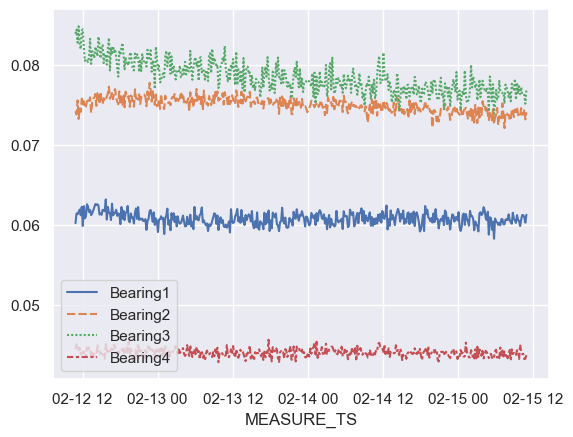

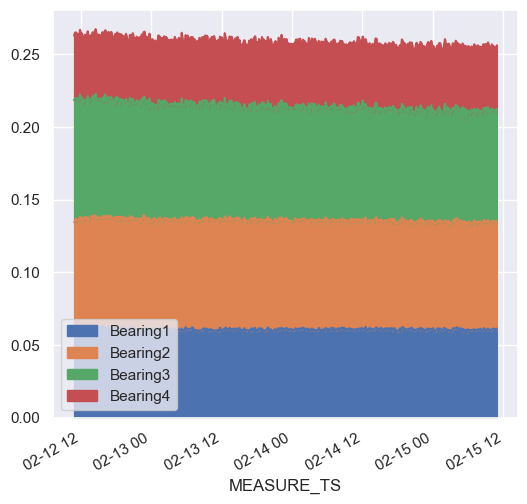

In [27]:
temp=train
testtemp=temp
temp.index = pd.to_datetime(temp.index)
sns.lineplot(data=temp)
plt.show()

#Area plot of all columns over time
temp=temp.drop(labels=['MEASURE_TS'],axis=1)
temp=temp.drop(labels=['OPERATOR_ID'],axis=1)
temp.plot.area(figsize=(6, 6))
plt.show()

In [31]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd
traintemp=train
testtemp=test
# Ensure MEASURE_TS is a column, and reset the index for both train and test DataFrames
train_numeric = traintemp.reset_index(drop=True)
test_numeric = testtemp.reset_index(drop=True)

# Drop non-numeric columns like MEASURE_TS from train_numeric and test_numeric
train_numeric = train_numeric.drop(columns=['MEASURE_TS'], errors='ignore')  # Ignore if 'MEASURE_TS' does not exist in DataFrame
test_numeric = test_numeric.drop(columns=['MEASURE_TS'], errors='ignore')

# Ensure that both DataFrames only contain numeric columns
train_numeric = train_numeric.select_dtypes(include=['float64', 'int64'])
test_numeric = test_numeric.select_dtypes(include=['float64', 'int64'])

# Check if there are only numeric columns
assert train_numeric.select_dtypes(include='number').shape[1] == train_numeric.shape[1], "Non-numeric columns found in train_numeric!"
assert test_numeric.select_dtypes(include='number').shape[1] == test_numeric.shape[1], "Non-numeric columns found in test_numeric!"

# Normalize only numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_numeric)
X_test_scaled = scaler.transform(test_numeric)

# Save the scaler for future use
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# Convert the scaled data back to DataFrame and reattach MEASURE_TS
X_train = pd.DataFrame(X_train_scaled, columns=train_numeric.columns)
X_test = pd.DataFrame(X_test_scaled, columns=test_numeric.columns)

print("X_train:")
print(X_train.head())

print("\nX_test:")
print(X_test.head())


['scaler_data']

In [33]:
import numpy as np

# Convert DataFrames to NumPy arrays before reshaping
X_train_array = X_train.values
X_test_array = X_test.values

# Reshape the inputs for LSTM [samples, timesteps, features]
X_train_array = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])
print("Training data shape:", X_train_array.shape)

X_test_array = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])
print("Test data shape:", X_test_array.shape)


Training data shape: (433, 1, 4)
Test data shape: (121, 1, 4)


## Model Building & Deployment

#### MODEL TRAINING

Stored Procedure to train the model using the training dataset

In [34]:

from sklearn.metrics import mean_squared_error
import snowflake.snowpark
from snowflake.snowpark import functions as F
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window

#from sklearn.model_selection import train_test_split
import joblib
import os
# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, StringType, StructType, FloatType, StructField, DateType, Variant
from snowflake.snowpark.functions import udf, sum, col,array_construct,month,year,call_udf,lit
from snowflake.snowpark.version import VERSION
import random

random.seed(392)

def train_lstm_model(session: Session) -> Variant:
    X_train = session.table("AE_TRAIN")
    X_train = X_train.to_pandas()
    #X_train = X_train.drop(columns=["MEASURE_TS"])
    X_train = X_train.drop(columns=['MEASURE_TS', 'FACTORY_FLOOR','PRODUCTION_UNIT','SHIFT',
                                   'OPERATOR_ID','MACHINE_STATUS'])
    X_train = X_train.to_numpy()
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    #model with five LSTM layers
    #L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    #L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    #L3 = RepeatVector(X_train.shape[1])(L2)
    #L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    #L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X_train.shape[2]))(inputs)    
    model = Model(inputs=inputs, outputs=output)

    optimizer=keras.optimizers.Adam(learning_rate=.001)
    model.compile(optimizer=optimizer, loss='mae')

    # fit the model to the data
    nb_epochs = 100
    batch_size = 10
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history
    
    from joblib import dump
    model_path = "/tmp/lstm_model.keras"
    model.save(model_path)
    print(f"Model saved to {model_path}.")
    return history



In [35]:
#Read the training data and reshape 
X_train = session.table("AE_TRAIN")
X_train = X_train.to_pandas()
X_train = X_train.drop(columns=["MEASURE_TS"])
X_train = X_train.to_numpy()
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_train


array([[[0.060236, 0.074227, 0.083926, 0.044443]],

       [[0.061455, 0.073844, 0.084457, 0.045081]],

       [[0.061361, 0.075609, 0.082837, 0.045118]],

       ...,

       [[0.060959, 0.074498, 0.076289, 0.043229]],

       [[0.060307, 0.073227, 0.075189, 0.04328 ]],

       [[0.061289, 0.074106, 0.076946, 0.043786]]])

In [ ]:
history = train_lstm_model(session)

In [ ]:
!ls /tmp

In [38]:
history = pd.DataFrame(history)

In [39]:
history.head()

,loss,val_loss
0,0.041025,0.014689
1,0.004591,0.000762
2,0.000931,0.001327
3,0.000913,0.000824
4,0.000953,0.000682


In [40]:
#Write the loss to a history table and keep track of model loss
session.sql("DROP table IF EXISTS AD_HISTORY").collect()
session.write_pandas(history,'AD_HISTORY',auto_create_table=True, overwrite=True)

In [ ]:
#Test local
model_path = "/tmp/lstm_model.keras"
model = keras.models.load_model(model_path)
print(f"Model loaded successfully")

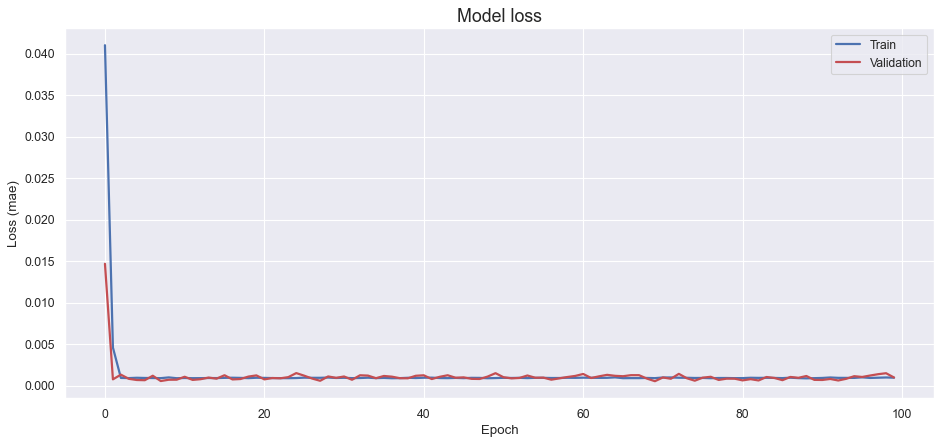

In [43]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
train_data = session.table("AE_TRAIN").limit(1).to_pandas()
train_data = train_data.set_index("MEASURE_TS")

In [ ]:
train_data = train_data.drop(columns=['FACTORY_FLOOR','PRODUCTION_UNIT','SHIFT',
                                   'OPERATOR_ID','MACHINE_STATUS'])

In [ ]:
train_data

In [ ]:
from snowflake.ml.model import custom_model

class AnomalyDetectionModel(custom_model.CustomModel):
    def __init__(self, context: custom_model.ModelContext) -> None:
        super().__init__(context)
        
    @custom_model.inference_api
    def predict(self, train_data: pd.DataFrame) -> pd.DataFrame:
        
        cols=train_data.columns
        scaler = MinMaxScaler()

        
        #X_train_pd = scaler.fit_transform(train_data)
        X_train_pd = train_data.to_numpy()
        X = X_train_pd.reshape(X_train_pd.shape[0], 1, X_train_pd.shape[1])
        X_pred = self.context.model_ref('lstm').predict(X)
        X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
        scored = np.abs(X_pred-X_train_pd)
        return pd.DataFrame(scored, columns=[f"feature_{i}" for i in range(scored.shape[1])])

ad = AnomalyDetectionModel(
    context=custom_model.ModelContext(models={'lstm': model})
)

In [ ]:
AnomalyDetectionModel

In [ ]:
# Log model to registry
ml_reg = Registry(session=session)

mv = ml_reg.log_model(
    ad,
    model_name="ANOMALYDETECTION_MODEL_1",
    version_name='v1',
    sample_input_data=train_data,
    conda_dependencies=["scikit-learn","keras==2.9","tensorflow==2.9"],
    options={"relax_version": True,
        "embed_local_ml_library": True
    }
)

Get the logged model from Model Registry

In [ ]:
# Usage Example
reg = Registry(session=session) 
model_ref = reg.show_models()

model_ref

In [ ]:
m = reg.get_model("ANOMALYDETECTION_MODEL_1")
mv = m.version("v1")

In [ ]:
X_train_snowdf = session.table("AE_TRAIN")
#X_pred = X_train_snowdf.with_column('Loss_mae', predict_anomaly([F.col(c) for c in X_train_snowdf.columns])).to_pandas()
X_pred = mv.run(X_train_snowdf, function_name="predict")

In [ ]:
X_pred

#### # Distribution of Loss Function

In [48]:
rename_mapping = {
    "feature_0": "TEMPERATURE_LOSS_MAE",
    "feature_1": "VIBRATION_LOSS_MAE",
    "feature_2": "MOTOR_RPM_LOSS_MAE",
    "feature_3": "MOTOR_AMPS_LOSS_MAE"
}
X_predpd= X_pred.to_pandas()
X_predpd = X_predpd.rename(columns=rename_mapping)

In [ ]:
X_predpd

#### CALCULATE LOSS MAE FOR EACH SENSOR AND PLOT IT

#### Visualize individual Sensors Loss Distribution

(0.0, 1.0)

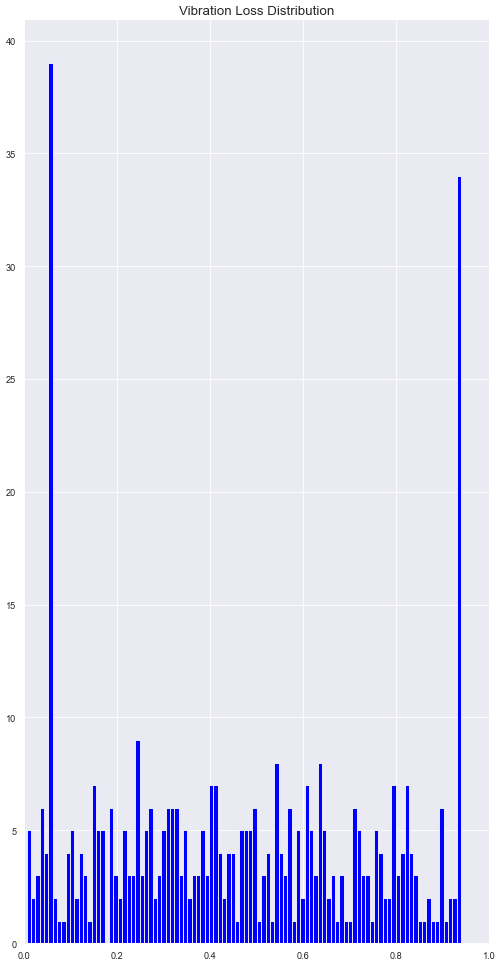

In [52]:
import matplotlib.pyplot as plt

# Assuming `X_predpd` is your DataFrame
plt.figure(figsize=(10, 6), dpi=100)  # Adjusted figure size for better proportions
plt.title('Vibration Loss Distribution', fontsize=16)

# Plot histogram with adjusted x-axis range and finer bins
vibration_mae = X_predpd['VIBRATION_LOSS_MAE']
plt.hist(vibration_mae, bins=50, color="blue", edgecolor='black', alpha=0.7)

# Dynamically set x-axis limits based on data
plt.xlim([vibration_mae.min() - 0.0001, vibration_mae.max() + 0.0001])
plt.xlabel('Vibration Loss MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for clarity
plt.show()


In [ ]:


# Assuming `X_predpd` is your DataFrame
plt.figure(figsize=(10, 6), dpi=100)  # Adjusted figure size for better proportions
plt.title('Temperature Loss Distribution', fontsize=16)

# Plot histogram with adjusted x-axis range and finer bins
vibration_mae = X_predpd['TEMPERATURE_LOSS_MAE']
plt.hist(vibration_mae, bins=50, color="blue", edgecolor='black', alpha=0.7)

# Dynamically set x-axis limits based on data
plt.xlim([vibration_mae.min() - 0.0001, vibration_mae.max() + 0.0001])
plt.xlabel('Temperature Loss MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for clarity
plt.show()


(0.0, 1.0)

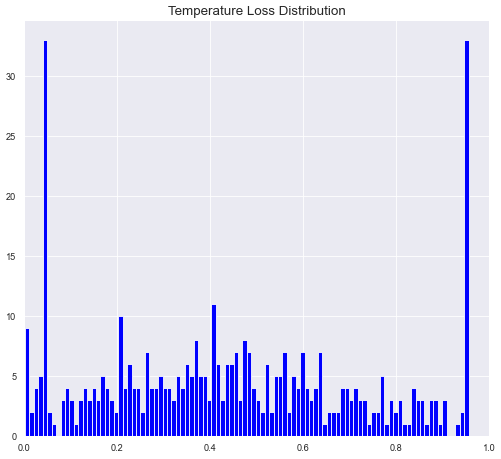

In [53]:


# Assuming `X_predpd` is your DataFrame
plt.figure(figsize=(10, 6), dpi=100)  # Adjusted figure size for better proportions
plt.title('MOTOR_RPM Loss Distribution', fontsize=16)

# Plot histogram with adjusted x-axis range and finer bins
vibration_mae = X_predpd['MOTOR_RPM_LOSS_MAE']
plt.hist(vibration_mae, bins=50, color="blue", edgecolor='black', alpha=0.7)

# Dynamically set x-axis limits based on data
plt.xlim([vibration_mae.min() - 0.0001, vibration_mae.max() + 0.0001])
plt.xlabel('MOTOR_RPM Loss MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for clarity
plt.show()


(0.0, 1.0)

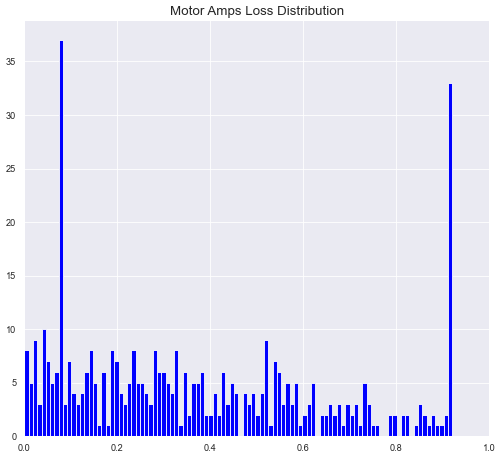

In [54]:


# Assuming `X_predpd` is your DataFrame
plt.figure(figsize=(10, 6), dpi=100)  # Adjusted figure size for better proportions
plt.title('MOTOR_AMPS Loss Distribution', fontsize=16)

# Plot histogram with adjusted x-axis range and finer bins
vibration_mae = X_predpd['MOTOR_AMPS_LOSS_MAE']
plt.hist(vibration_mae, bins=50, color="blue", edgecolor='black', alpha=0.7)

# Dynamically set x-axis limits based on data
plt.xlim([vibration_mae.min() - 0.0001, vibration_mae.max() + 0.0001])
plt.xlabel('MOTOR_AMPS Loss MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', alpha=0.75)  # Optional: Add grid lines for clarity
plt.show()


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
X_predpd1=X_predpd.drop(columns=["MEASURE_TS"])
X_predpd1=X_predpd.drop(columns=['FACTORY_FLOOR','PRODUCTION_UNIT','SHIFT',
                                   'OPERATOR_ID','MACHINE_STATUS'])

# Set up the figure size and title
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Loss Distribution', fontsize=16)

# Plot KDE for each loss column
sns.kdeplot(X_predpd1['VIBRATION_LOSS_MAE'], label='VIBRATION_LOSS_MAE', color='blue', fill=True, alpha=0.4)
sns.kdeplot(X_predpd1['MOTOR_RPM_LOSS_MAE'], label='MOTOR_RPM_LOSS_MAE', color='red', fill=True, alpha=0.4)
sns.kdeplot(X_predpd1['MOTOR_AMPS_LOSS_MAE'], label='MOTOR_AMPS_LOSS_MAE', color='yellow', fill=True, alpha=0.4)
sns.kdeplot(X_predpd1['TEMPERATURE_LOSS_MAE'], label='TEMPERATURE_LOSS_MAE', color='green', fill=True, alpha=0.4)

# Adjust x-axis limits dynamically to better fit small values

plt.xlabel('Loss MAE', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sensors', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [60]:
# Get reconstruction loss threshold for each sensor.

Threshold_TEMPERATURE= np.max(X_predpd['TEMPERATURE_LOSS_MAE'])
print("Reconstruction error threshold: ", Threshold_TEMPERATURE)


Reconstruction error threshold:  0.9561318010091782


In [61]:
Threshold_VIBRATION= np.max(X_predpd['VIBRATION_LOSS_MAE'])
print("Reconstruction error threshold: ", Threshold_VIBRATION)


Reconstruction error threshold:  0.939365115016698


In [62]:
Threshold_MOTOR_AMPS= np.max(X_predpd['MOTOR_AMPS_LOSS_MAE'])
print("Reconstruction error threshold: ", Threshold_MOTOR_AMPS)


Reconstruction error threshold:  0.920528523623943


In [63]:
Threshold_MOTOR_RPM= np.max(X_predpd['MOTOR_RPM_LOSS_MAE'])
print("Reconstruction error threshold: ", Threshold_MOTOR_RPM)

Reconstruction error threshold:  0.92542383819818


In [ ]:
X_test_snowdf = session.table("AE_TEST")
X_predTest = mv.run(X_test_snowdf, function_name="predict")

In [ ]:
rename_mapping = {
    "feature_0": "TEMPERATURE_LOSS_MAE",
    "feature_1": "VIBRATION_LOSS_MAE",
    "feature_2": "MOTOR_RPM_LOSS_MAE",
    "feature_3": "MOTOR_AMPS_LOSS_MAE"
}
X_predtestpd= X_predTest.to_pandas()
X_predtestpd = X_predtestpd.rename(columns=rename_mapping)

In [65]:
X_predtestpd

In [66]:
#Set the Threshold calculated for the test data 
X_predtestpd['Threshold_VIBRATION']= Threshold_VIBRATION
X_predtestpd['Threshold_MOTOR_AMPS']= Threshold_MOTOR_AMPS
X_predtestpd['Threshold_MOTOR_RPM']= Threshold_MOTOR_RPM
X_predtestpd['Threshold_TEMPERATURE']= Threshold_TEMPERATURE


## Detect Anomalies

In [68]:
#Determine anomaly in each sensor
X_predtestpd['Anomaly_in_vibration_sensor'] = X_predtestpd['VIBRATION_LOSS_MAE'] > X_predtestpd['Threshold_VIBRATION']
X_predtestpd['Anomaly_in_temperature_sensor'] = X_predtestpd['TEMPERATURE_LOSS_MAE'] > X_predtestpd['Threshold_TEMPERATURE']
X_predtestpd['Anomaly_in_motor_amps_sensor'] = X_predtestpd['MOTOR_AMPS_LOSS_MAE'] > X_predtestpd['Threshold_MOTOR_AMPS']
X_predtestpd['Anomaly_in_motor_rpm_sensor'] = X_predtestpd['MOTOR_RPM_LOSS_MAE'] > X_predtestpd['Threshold_MOTOR_RPM']


In [69]:
#Combine anomalies across all sensors
snow_pred_test_final = X_predtestpd[['Anomaly_in_vibration_sensor', 'Anomaly_in_temperature_sensor', 'Anomaly_in_motor_amps_sensor','Anomaly_in_motor_rpm_sensor']].head()

In [73]:
#Set the Threshold calculated for the training data 
X_predpd['Threshold_VIBRATION']= Threshold_VIBRATION
X_predpd['Threshold_MOTOR_AMPS']= Threshold_MOTOR_AMPS
X_predpd['Threshold_MOTOR_RPM']= Threshold_MOTOR_RPM
X_predpd['Threshold_TEMPERATURE']= Threshold_TEMPERATURE

#Determine anomaly
X_predpd['Anomaly_in_vibration_sensor'] = X_predpd['VIBRATION_LOSS_MAE'] > X_predpd['Threshold_VIBRATION']
X_predpd['Anomaly_in_temperature_sensor'] = X_predpd['TEMPERATURE_LOSS_MAE'] > X_predpd['Threshold_TEMPERATURE']
X_predpd['Anomaly_in_motor_amps_sensor'] = X_predpd['MOTOR_AMPS_LOSS_MAE'] > X_predpd['Threshold_MOTOR_AMPS']
X_predpd['Anomaly_in_motor_rpm_sensor'] = X_predpd['MOTOR_RPM_LOSS_MAE'] > X_predpd['Threshold_MOTOR_RPM']




In [75]:
X_predtestpd

,MEASURE_TS,Threshold_VIBRATION,Threshold_MOTOR_AMPS,Threshold_MOTOR_RPM,Threshold_TEMPERATURE,VIBRATION_LOSS_MAE,MOTOR_RPM_LOSS_MAE,MOTOR_AMPS_LOSS_MAE,TEMPERATURE_LOSS_MAE,Anomaly_in_vibration_sensor,Anomaly_in_temperature_sensor,Anomaly_in_motor_amps_sensor,Anomaly_in_motor_rpm_sensor
0,2023-02-15 12:52:39,0.939365,0.920529,0.925424,0.956132,0.131665,0.925426,0.377807,0.654359,False,False,False,True
1,2023-02-15 13:02:39,0.939365,0.920529,0.925424,0.956132,0.060586,0.114354,0.079265,0.221558,False,False,False,False
2,2023-02-15 13:12:39,0.939365,0.920529,0.925424,0.956132,0.048953,0.074490,0.457609,0.043867,False,False,False,False
3,2023-02-15 13:22:39,0.939365,0.920529,0.925424,0.956132,0.939273,0.648620,0.920407,0.956110,False,False,False,False
4,2023-02-15 13:32:39,0.939365,0.920529,0.925424,0.956132,0.301859,0.925423,0.221213,0.956121,False,False,False,False


In [76]:
# Merge all data in a single dataframe for plotting
scored = pd.concat([X_predpd, X_predtestpd])
scored.head()

,MEASURE_TS,VIBRATION_LOSS_MAE,MOTOR_RPM_LOSS_MAE,MOTOR_AMPS_LOSS_MAE,TEMPERATURE_LOSS_MAE,Threshold_VIBRATION,Threshold_MOTOR_AMPS,Threshold_MOTOR_RPM,Threshold_TEMPERATURE,Anomaly_in_vibration_sensor,Anomaly_in_temperature_sensor,Anomaly_in_motor_amps_sensor,Anomaly_in_motor_rpm_sensor
0,2023-02-12 10:52:39,0.939293,0.761301,0.696337,0.651154,0.939365,0.920529,0.925424,0.956132,False,False,False,False
1,2023-02-12 11:02:39,0.916920,0.925325,0.920379,0.765048,0.939365,0.920529,0.925424,0.956132,False,False,False,False
2,2023-02-12 11:12:39,0.284100,0.570945,0.276087,0.471132,0.939365,0.920529,0.925424,0.956132,False,False,False,False
3,2023-02-12 11:22:39,0.304986,0.856063,0.556761,0.532972,0.939365,0.920529,0.925424,0.956132,False,False,False,False
4,2023-02-12 11:32:39,0.353903,0.798540,0.659399,0.594207,0.939365,0.920529,0.925424,0.956132,False,False,False,False


In [77]:
#Anomaly if found in even one sensor is marked
anomaly_sensors = ['Anomaly_in_vibration_sensor', 'Anomaly_in_temperature_sensor','Anomaly_in_motor_amps_sensor','Anomaly_in_motor_rpm_sensor']
scored['Anomaly_detected']=scored[anomaly_sensors].any(axis=1)
scored

,MEASURE_TS,VIBRATION_LOSS_MAE,MOTOR_RPM_LOSS_MAE,MOTOR_AMPS_LOSS_MAE,TEMPERATURE_LOSS_MAE,Threshold_VIBRATION,Threshold_MOTOR_AMPS,Threshold_MOTOR_RPM,Threshold_TEMPERATURE,Anomaly_in_vibration_sensor,Anomaly_in_temperature_sensor,Anomaly_in_motor_amps_sensor,Anomaly_in_motor_rpm_sensor,Anomaly
0,2023-02-12 10:52:39,0.939293,0.761301,0.696337,0.651154,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
1,2023-02-12 11:02:39,0.916920,0.925325,0.920379,0.765048,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
2,2023-02-12 11:12:39,0.284100,0.570945,0.276087,0.471132,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
3,2023-02-12 11:22:39,0.304986,0.856063,0.556761,0.532972,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
4,2023-02-12 11:32:39,0.353903,0.798540,0.659399,0.594207,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-02-16 08:12:39,0.939256,0.925317,0.920367,0.956107,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
117,2023-02-16 08:22:39,0.060580,0.173083,0.079251,0.073225,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
118,2023-02-16 08:32:39,0.047465,0.925394,0.786056,0.023864,0.939365,0.920529,0.925424,0.956132,False,False,False,False,False
119,2023-02-16 08:42:39,0.087349,0.017148,0.920546,0.043877,0.939365,0.920529,0.925424,0.956132,False,False,True,False,True


In [78]:
#Data with anomalies 
scored[scored.Anomaly_detected==True]

,MEASURE_TS,VIBRATION_LOSS_MAE,MOTOR_RPM_LOSS_MAE,MOTOR_AMPS_LOSS_MAE,TEMPERATURE_LOSS_MAE,Threshold_VIBRATION,Threshold_MOTOR_AMPS,Threshold_MOTOR_RPM,Threshold_TEMPERATURE,Anomaly_in_vibration_sensor,Anomaly_in_temperature_sensor,Anomaly_in_motor_amps_sensor,Anomaly_in_motor_rpm_sensor,Anomaly
0,2023-02-15 12:52:39,0.131665,0.925426,0.377807,0.654359,0.939365,0.920529,0.925424,0.956132,False,False,False,True,True
11,2023-02-15 14:42:39,0.939367,0.127059,0.085962,0.699507,0.939365,0.920529,0.925424,0.956132,True,False,False,False,True
15,2023-02-15 15:22:39,0.939393,0.074472,0.079314,0.043865,0.939365,0.920529,0.925424,0.956132,True,False,False,False,True
23,2023-02-15 16:42:39,0.939371,0.074506,0.019978,0.956131,0.939365,0.920529,0.925424,0.956132,True,False,False,False,True
39,2023-02-15 19:22:39,0.939374,0.074502,0.079360,0.946924,0.939365,0.920529,0.925424,0.956132,True,False,False,False,True
41,2023-02-15 19:42:39,0.054297,0.160299,0.920542,0.043878,0.939365,0.920529,0.925424,0.956132,False,False,True,False,True
43,2023-02-15 20:02:39,0.939337,0.925441,0.079446,0.956124,0.939365,0.920529,0.925424,0.956132,False,False,False,True,True
58,2023-02-15 22:32:39,0.939367,0.074512,0.098781,0.956130,0.939365,0.920529,0.925424,0.956132,True,False,False,False,True
62,2023-02-15 23:12:39,0.060609,0.074472,0.079306,0.956138,0.939365,0.920529,0.925424,0.956132,False,True,False,False,True
72,2023-02-16 00:52:39,0.337248,0.925511,0.079341,0.006511,0.939365,0.920529,0.925424,0.956132,False,False,False,True,True


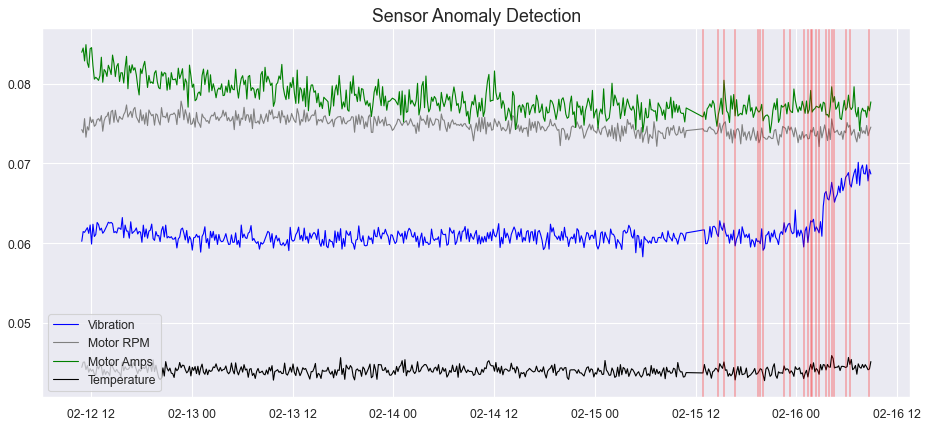

In [80]:
#Concat train and test data and plot the anomalies detected
merge_test = session.table("AE_TEST").to_pandas()
merge_test.index=test.index

merge_train = session.table("AE_TRAIN").to_pandas()
merge_train.index=train.index

merge_concat=pd.concat([merge_train, merge_test])

merge_concat.reindex()
scored.index = merge_concat.index

merge_concat['Anomaly_detected']=scored['Anomaly_detected']

anomalies=merge_concat[merge_concat['Anomaly_detected']==True].index
merge_concat

In [ ]:
merge_concat = merge_concat.reset_index(drop=True)

# Set 'MEASURE_TS' as the new index
merge_concat = merge_concat.set_index('MEASURE_TS')

# Drop 'MEASURE_TS' from the column list (it's already set as the index)
merge_concat.columns = merge_concat.columns.drop('MEASURE_TS', errors='ignore')

# The DataFrame now has 'MEASURE_TS' as the index and no longer appears as a column
print(merge_concat.head())

In [ ]:
merge_concat.index = pd.to_datetime(merge_concat.index)

# Plot the data
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

# Plot each sensor's data
ax.plot(merge_concat.index, merge_concat['VIBRATION'], label='Vibration', color='blue', linewidth=1)
ax.plot(merge_concat.index, merge_concat['MOTOR_RPM'], label='Motor RPM', color='gray', linewidth=1)
ax.plot(merge_concat.index, merge_concat['MOTOR_AMPS'], label='Motor Amps', color='green', linewidth=1)
ax.plot(merge_concat.index, merge_concat['TEMPERATURE'], label='Temperature', color='black', linewidth=1)

# Plot anomalies
anomaly_indices = merge_concat[merge_concat['Anomaly_detected'] == True].index
for anomaly in anomaly_indices:
    plt.axvline(x=anomaly, color='red', alpha=0.3)

# Customize the plot
plt.legend(loc='lower left')
ax.set_title('Sensor Anomaly Detection', fontsize=16)
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylabel('Sensor Values', fontsize=12)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))  # Format datetime

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
merge_concat.reset_index(inplace=True)
merge_concat['MEASURE_TS'] = pd.to_datetime(merge_concat['MEASURE_TS'], unit='s')
merge_concat['ANOMALY'] = merge_concat['Anomaly_detected'].astype(str)

merge_concatDF=session.create_dataframe(merge_concat)
merge_concatDF=merge_concatDF.drop(F.col('"Anomaly_detected"'))

In [ ]:
#Write Anomaly Detected information to a Snowflake table

merge_concatDF.write.save_as_table("SENSORS_AD_DETECTED", mode="overwrite")

In [ ]:
session.sql(f"""CREATE OR REPLACE CORTEX SEARCH SERVICE cortex_search_production_data
ON listing_text
WAREHOUSE = {solution_prefix}
TARGET_LAG = '1 hour'
AS
    SELECT
TEMPERATURE,VIBRATION, MOTOR_RPM,  MOTOR_AMPS,MEASURE_TS,ANOMALY,FACTORY_FLOOR,PRODUCTION_UNIT,SHIFT,
                                   OPERATOR_ID,MACHINE_STATUS,
        ('TEMPERATURE\n\n' || TEMPERATURE || '\n\n\VIBRATION\n\n' || VIBRATION || '\n\n\\MOTOR_RPM\n\n' || MOTOR_RPM || 
    'MOTOR_AMPS\n\n' || MOTOR_AMPS || 
    'MEASURE_TS\n\n' || MEASURE_TS || 
    'ANOMALY\n\n' || ANOMALY ||
    'FACTORY_FLOOR\n\n' || FACTORY_FLOOR || 
    'PRODUCTION_UNIT\n\n' || PRODUCTION_UNIT || 
    'SHIFT\n\n' || SHIFT || 
    'OPERATOR_ID\n\n' || OPERATOR_ID || 
    'MACHINE_STATUS\n\n' || MACHINE_STATUS) as listing_text
    FROM
    sensors_ad_detected""")

## Summary
The objective to detect anomalies in sensor data by training a Keras LSTM Auto-encoder model is successfully achieved on Snowflake.